In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import re
from models import *
from plot_utils import *
from math import ceil
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
plt.rcParams['figure.figsize'] = (10, 6.5)
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 4

sns.set_style('ticks')
sns.set_palette('Paired', 10)

In [20]:
rmse_df = pd.read_csv('rmse.csv')
sampling_df = pd.read_csv('timing-results/sampling-time.csv')

simdex_netflix_df = pd.read_csv('timing-results/netflix-simdex-timing.csv')
lemp_netflix_df = pd.read_csv('timing-results/netflix-lemp-timing.csv')
blocked_mm_netflix_df = pd.read_csv('timing-results/netflix-blocked_mm-timing.csv')

simdex_kdd_df = pd.read_csv('timing-results/kdd-simdex-timing.csv')
lemp_kdd_df = pd.read_csv('timing-results/kdd-lemp-timing.csv')
blocked_mm_kdd_df = pd.read_csv('timing-results/kdd-blocked_mm-timing.csv')

simdex_r2_df = pd.read_csv('timing-results/r2-simdex-timing.csv')
lemp_r2_df = pd.read_csv('timing-results/r2-lemp-timing.csv')
blocked_mm_r2_df = pd.read_csv('timing-results/r2-blocked_mm-timing.csv')

simdex_df = pd.concat([simdex_netflix_df, simdex_kdd_df, simdex_r2_df])
lemp_df = pd.concat([lemp_netflix_df, lemp_kdd_df, lemp_r2_df])
blocked_mm_df = pd.concat([blocked_mm_netflix_df, blocked_mm_kdd_df, blocked_mm_r2_df])
both_df = pd.concat([simdex_df, blocked_mm_df])

In [21]:
fexipro_df_all = pd.read_csv('timing-results/fexipro-orig-timing.csv')
fexipro_df = fexipro_df_all.query('alg == "SIR"')
fexipro_si_df = fexipro_df_all.query('alg == "SI"')

In [22]:
simdex_df.sort_values(by='comp_time').groupby(
        ['model', 'K'], as_index=False).first().drop(['num_threads','num_latent_factors',
                                                     'num_bins','sample_percentage',
                                                      'num_iters', 'parse_time'], axis=1)

,model,K,batch_size,num_clusters,cluster_time,index_time,algo_time,comp_time
0,fexipro-paper-Netflix-50,1,4096,8,0.306038,0.114570,76.16210,76.58270
1,fexipro-paper-Netflix-50,5,4096,8,0.287685,0.116404,86.53100,86.93500
2,fexipro-paper-Netflix-50,10,4096,8,0.296590,0.116511,85.45260,85.86570
3,fexipro-paper-Netflix-50,50,4096,8,0.292802,0.114367,89.01350,89.42070
4,lemp-paper-KDD-50,1,4096,8,1.740070,14.537800,5295.48000,5311.75000
5,lemp-paper-KDD-50,5,4096,8,1.709020,14.623800,8356.78000,8373.12000
6,lemp-paper-KDD-50,10,4096,8,1.741060,15.241800,10143.30000,10160.30000
7,lemp-paper-KDD-50,50,4096,8,1.850200,14.513700,14560.80000,14577.10000
8,lemp-paper-Netflix-50,1,4096,1,0.105940,0.097753,21.77010,21.97380
9,lemp-paper-Netflix-50,5,1024,1,0.105965,0.098666,25.24710,25.45170


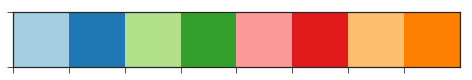

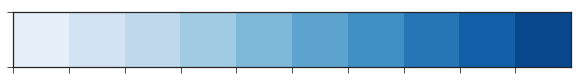

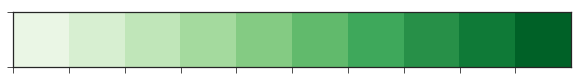

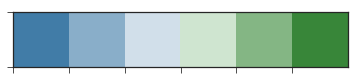

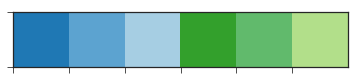

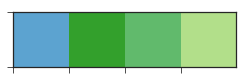

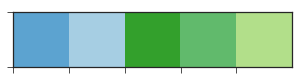

In [6]:
palette = sns.color_palette('Paired', 4)
blue_palette = sns.color_palette('Blues', 10)
green_palette = sns.color_palette('Greens', 10)
f_u_palette = [palette[1], blue_palette[-5], palette[0], palette[3], green_palette[-5], palette[2]]
# appetizer_palette = [palette[1], palette[3]]
appetizer_palette = f_u_palette[1:2] + f_u_palette[3:]
# rmse_reg_palette = [palette[1], palette[0], palette[3]]
rmse_reg_palette = [blue_palette[-5], palette[0], palette[3], green_palette[-5], palette[2]]
# rmse_reg_palette = [f_u_palette[3], f_u_palette[1], f_u_palette[4], f_u_palette[2], f_u_palette[5]]

sns.palplot(sns.color_palette('Paired', 8))
sns.palplot(sns.color_palette('Blues', 10))
sns.palplot(sns.color_palette('Greens', 10))
sns.palplot(sns.diverging_palette(240, 128, n=6))
sns.palplot(f_u_palette)
sns.palplot(appetizer_palette)
sns.palplot(rmse_reg_palette)

/Users/fabuzaid/Documents/simdex/code/plots/plot_utils.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocked_mm_rt['algo'] = 'Blocked MM Only'
/Users/fabuzaid/Documents/simdex/code/plots/plot_utils.py:468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lemp_rt['algo'] = 'LEMP'
/Users/fabuzaid/Documents/simdex/code/plots/plot_utils.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

lemp-paper-Netflix-noav-10 0.0217379101644
1 512 1
5 1024 1
10 1024 1
50 1024 1
lemp-paper-Netflix-noav-50 0.0112690255378
1 4096 1
5 4096 1
10 4096 1
50 4096 1
lemp-paper-Netflix-noav-100 0.0147450674175
1 4096 1
5 4096 1
10 4096 1
50 4096 8
lemp-paper-KDD-50 0.00142949604104
1 4096 8
5 4096 8
10 4096 8
50 4096 8
nomad-Netflix-10-reg-0.05 0.0208781452364
1 1024 1
5 1024 1
10 256 1
50 1024 1
nomad-Netflix-25-reg-0.05 0.012695611325
1 1024 1
5 1024 1
10 1024 1
50 1024 1
nomad-Netflix-50-reg-0.05 0.0119242738849
1 1024 1
5 1024 1
10 1024 1
50 1024 1
nomad-Netflix-100-reg-0.05 0.0145830060313
1 4096 1
5 4096 1
10 4096 1
50 1024 1
nomad-R2-10-reg-0.001 0.0096215130276
1 1024 1
5 1024 1
10 1024 1
50 512 1
nomad-R2-25-reg-0.001 0.0629571832634
1 512 2
5 512 1
10 512 4
50 512 1
nomad-R2-50-reg-0.000001 0.00595248046041
1 512 1
5 512 4
10 512 8
50 1024 1
nomad-R2-100-reg-0 0.0103436766246
1 1024 2
5 1024 1
10 1024 1
50 1024 4
nomad-KDD-10-reg-1 0.00515787848636
1 1024 1
5 1024 2
10 2048 8
50 4

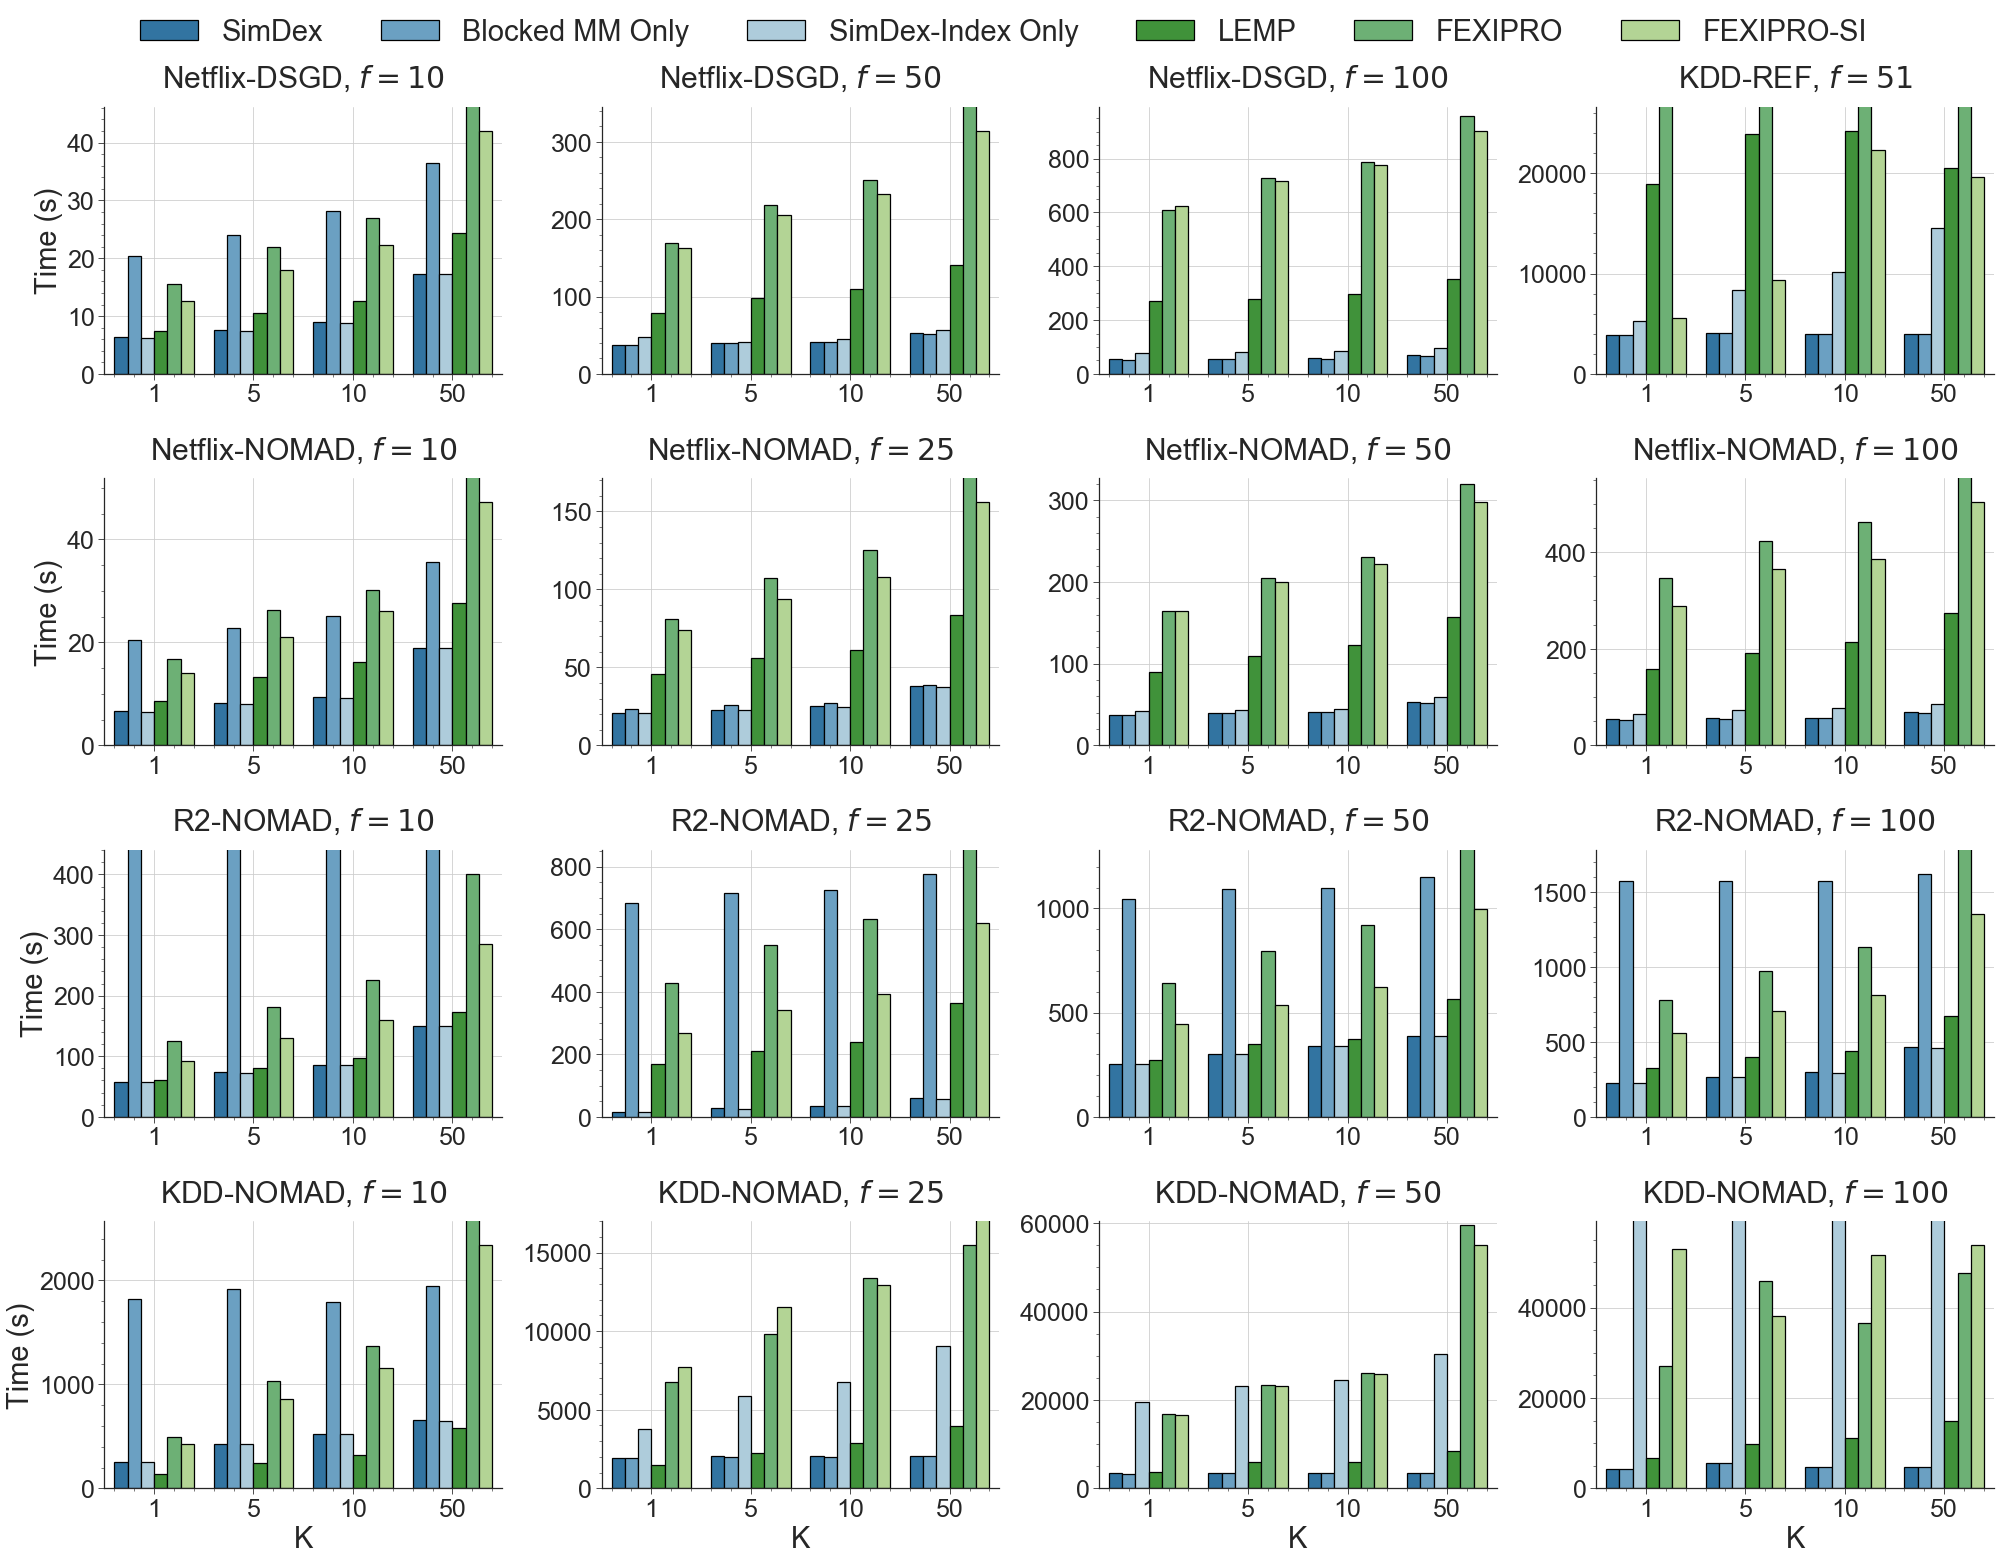

In [17]:
with sns.color_palette(f_u_palette):
    f_u_plots(simdex_df, lemp_df, blocked_mm_df, fexipro_df, fexipro_si_df, sampling_df,
              GOLD_STANDARD_MODELS, figsize=(28, 21),
              bbox_to_anchor=(0,0,1, 1.04), nrows=4)

In [ ]:
with sns.color_palette(appetizer_palette):
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-R2-50-reg-0.001', y_title=1.01, figsize=(7, 5.5), title=r'Yahoo Music R2, $f=50$')
    blocked_mm_lemp_fexipro_plot(blocked_mm_df, lemp_df, fexipro_df, fexipro_si_df,
                             'nomad-Netflix-50-reg-0.05', y_title=1.01, figsize=(7, 5.5),
                             title=r'Netflix Prize, $f=50$')

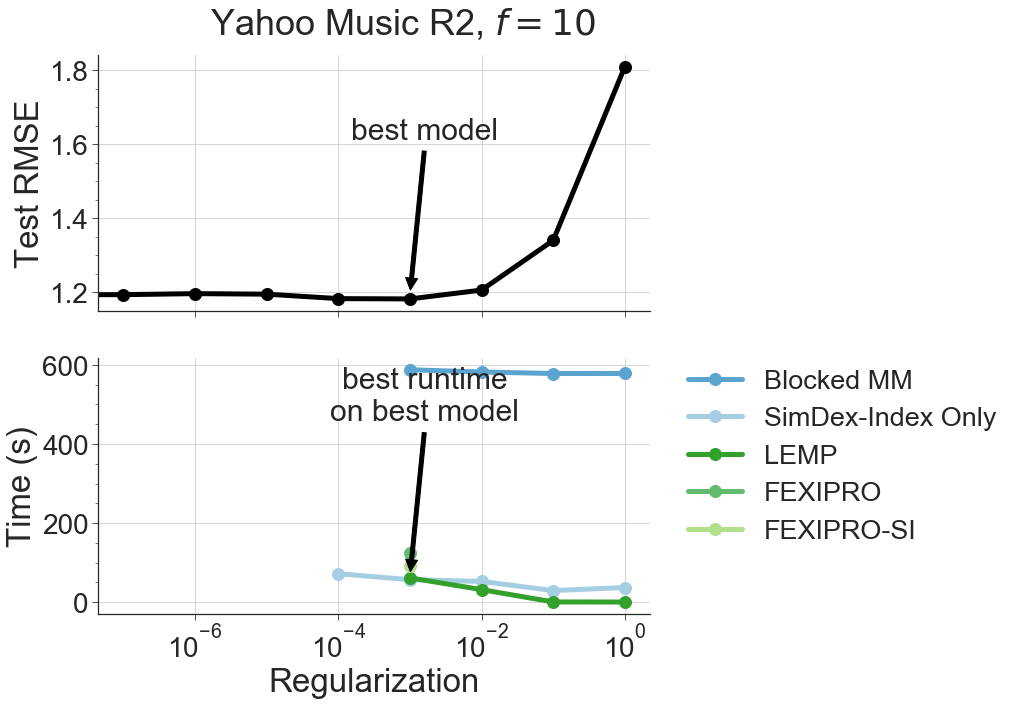

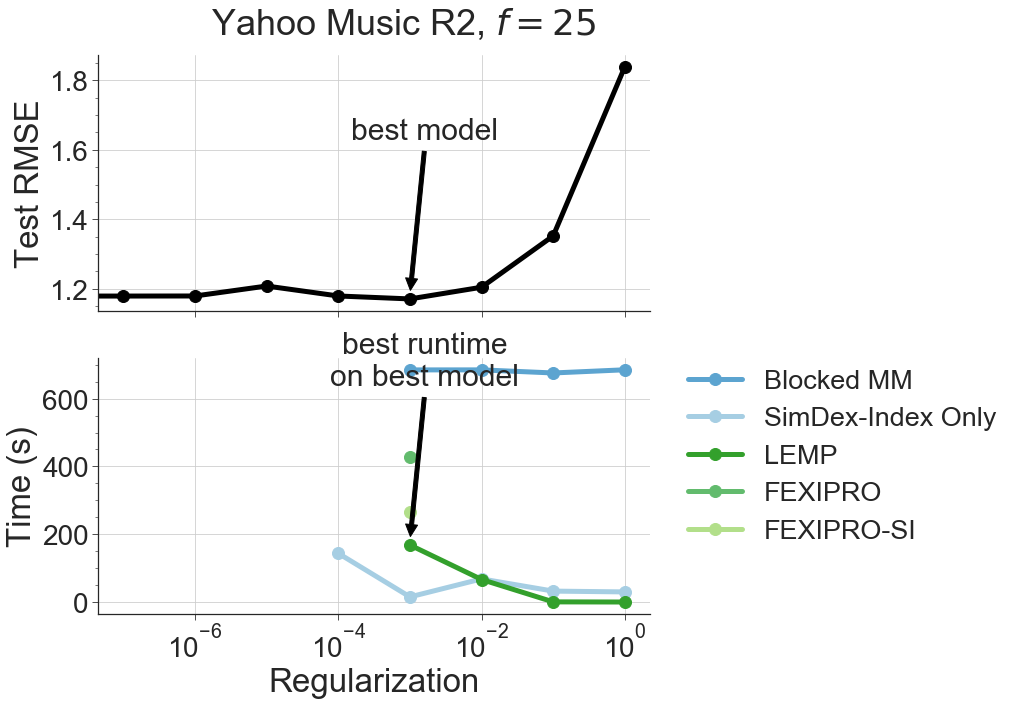

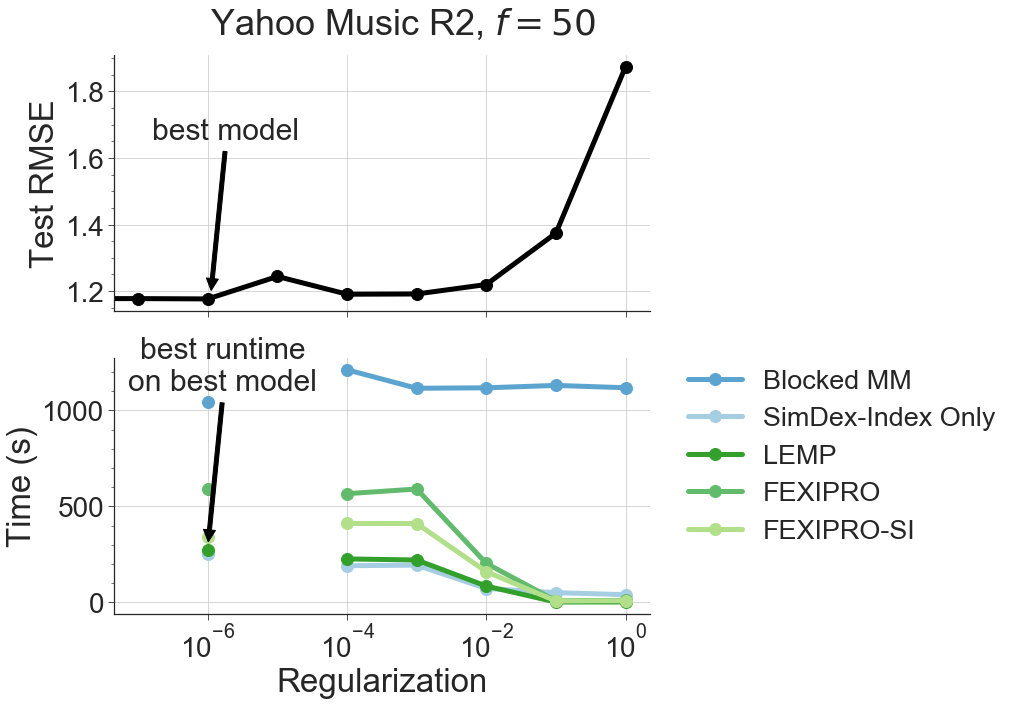

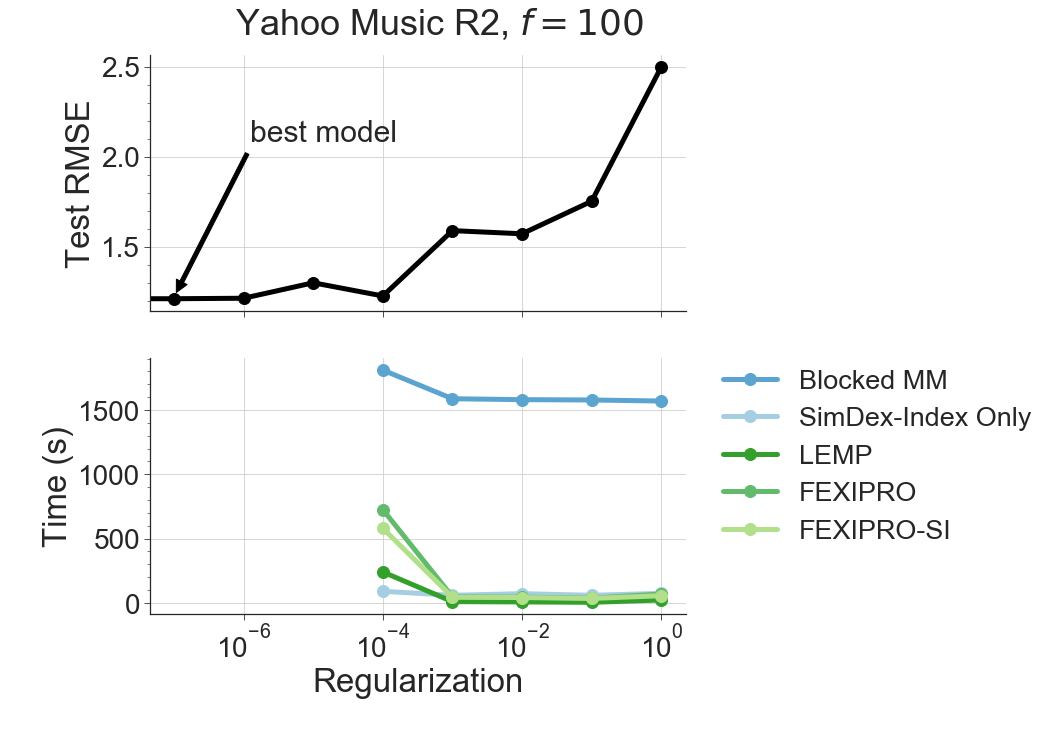

In [21]:
# custom settings for the line plots
plt.rcParams['font.size'] = 33
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['figure.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 33
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['legend.fontsize'] = 27
plt.rcParams['lines.markersize'] = 12
plt.rcParams['lines.linewidth'] = 5

appetizer_models = [
    ('nomad-Netflix-50', NETFLIX_REGS, (15, 135), r'Netflix Prize, $f=50$'),
    ('nomad-R2-50', R2_REGS, (150, 75), r'Yahoo Music R2, $f=50$')    
]

all_models = [
#     ('nomad-Netflix-100', NETFLIX_REGS, (15, 150), r'Netflix Prize, $f=100$'),
    ('nomad-R2-10', R2_REGS, (15, 150), r'Yahoo Music R2, $f=10$'),
    ('nomad-R2-25', R2_REGS, (15, 150), r'Yahoo Music R2, $f=25$'),
    ('nomad-R2-50', R2_REGS, (15, 150), r'Yahoo Music R2, $f=50$'),
    ('nomad-R2-100', R2_REGS,(150, 150), r'Yahoo Music R2, $f=100$'),
]
for add_simdex in [True]:
    models = all_models if add_simdex else appetizer_models
    _palette = rmse_reg_palette if add_simdex else appetizer_palette
    for model_prefix, regs, xy_text, title_text in models:
        _simdex_df = simdex_df if add_simdex else None
        fname = 'appetizer-' + model_prefix if not add_simdex else None
        with sns.color_palette(_palette):
            rmse_and_reg_plots(blocked_mm_df, lemp_df, rmse_df, model_prefix, regs,
                               simdex_df=_simdex_df, fexipro_df=fexipro_df, fexipro_si_df=fexipro_si_df,
                               fname=fname, figsize=(10, 10),
                               bbox_to_anchor=(0,0,1,1.05), title=True, title_text=title_text, 
                               y_title=1.01, annotate=add_simdex, xy_text=xy_text, linestyle='-',
                               include_legend=True)
#             rmse_and_reg_legend(add_simdex)
     
# return to normal
plt.rcParams['font.size'] = 29
plt.rcParams['font.weight'] = 500
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.labelsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4        
sns.set_palette('Paired', 10)


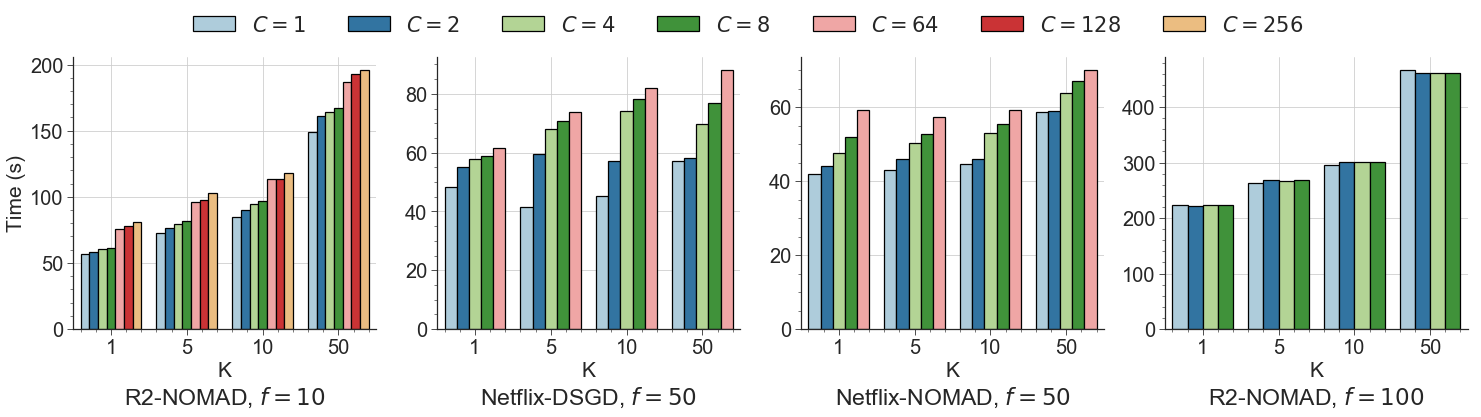

In [24]:
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 21
num_clusters_vs_runtime(simdex_df, ['nomad-R2-10-reg-0.001',
                                    'lemp-paper-Netflix-noav-50',
                                    'nomad-Netflix-50-reg-0.05',
                                    'nomad-R2-100-reg-0',
                                   ], figsize=(25, 5), y_title=-0.3,
                            bbox_to_anchor=(0,0,1,1.05), min_value=0, max_value=512)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 29
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.labelsize'] = 29

nomad-Netflix-50-reg-0.05 1 1
nomad-Netflix-50-reg-0.05 5 1
nomad-Netflix-50-reg-0.05 10 1
nomad-Netflix-50-reg-0.05 50 1
nomad-R2-50-reg-0.000001 1 1
nomad-R2-50-reg-0.000001 5 4
nomad-R2-50-reg-0.000001 10 8
nomad-R2-50-reg-0.000001 50 1
nomad-R2-100-reg-0 1 2
nomad-R2-100-reg-0 5 1
nomad-R2-100-reg-0 10 1
nomad-R2-100-reg-0 50 4
lemp-paper-Netflix-noav-50 1 1
lemp-paper-Netflix-noav-50 5 1
lemp-paper-Netflix-noav-50 10 1
lemp-paper-Netflix-noav-50 50 1


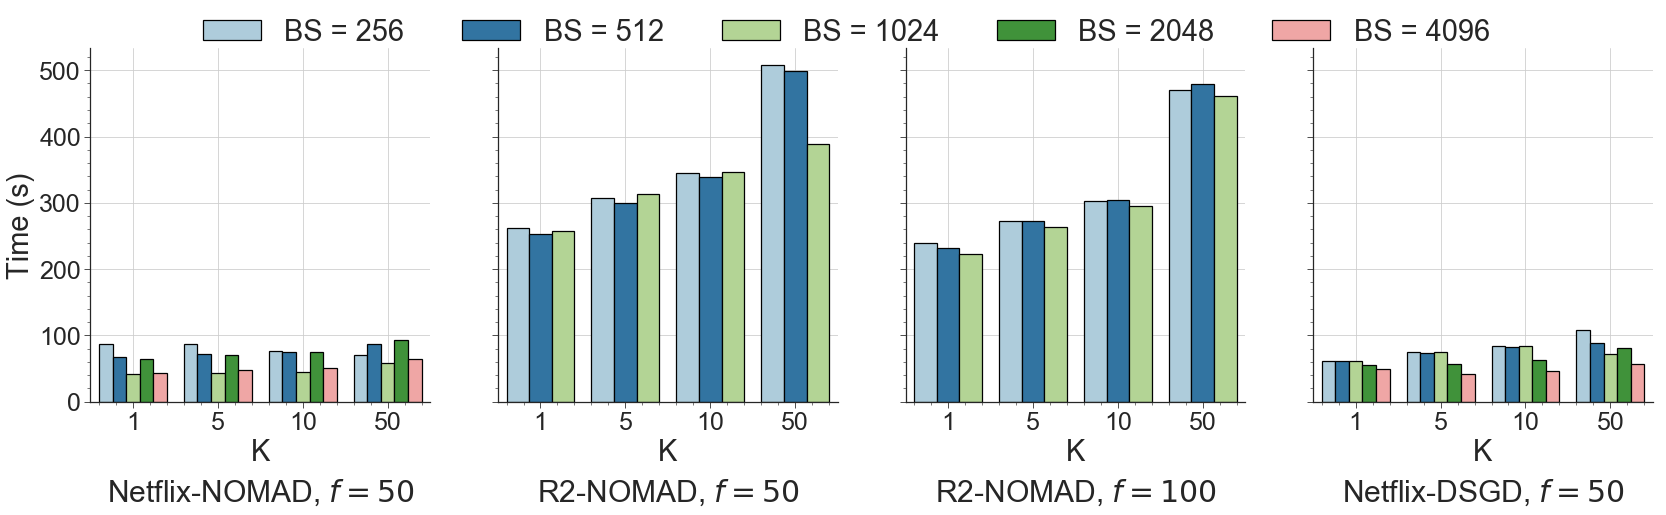

In [25]:
batch_size_vs_runtime(simdex_df, ['nomad-Netflix-50-reg-0.05',
                                  'nomad-R2-50-reg-0.000001',
                                  'nomad-R2-100-reg-0',
                                  'lemp-paper-Netflix-noav-50',], y_title=-0.3)

In [ ]:
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['lines.linewidth'] = 6
with sns.color_palette(f_u_palette):
    point_query_time(['lemp-paper-Netflix-noav-50', 'nomad-Netflix-50-reg-0.05',
                      'nomad-R2-50-reg-0.001', 'nomad-KDD-50-reg-1'],
                     csv_dir='point-query-stats/', figsize=(32, 6.5),
                     sample_fraction=1.0, y_title=-0.38)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['lines.linewidth'] = 4

In [ ]:
plt.rcParams['font.size'] = 25
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['lines.markersize'] = 11
plt.rcParams['lines.linewidth'] = 2.50

factor_analysis(figsize=(8,4))